# Clean trajectory
This notebook presents a general cleaning process to clean a moving pandas trajectory loaded from gpx file

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import gpxpy
import gpxpy.gpx
from fiona.crs import from_epsg
from keplergl import KeplerGl
import geopandas as gpd
import movingpandas as mpd
import uuid
import hvplot.pandas
from pyproj import CRS


In [2]:
# this cell has been tagged with "parameters"

# Having the fetching code in the parameters cell allows dagster to overwrite this cell and replace
# it with the contents of the upstream dataset asset. If you want to run the notebook locally, this
# cell will remain, which allows you to fetch the dataset directly.

file_path = '../data/MG91/MG91_ artefacto_reloj_20230505_01.gpx'
file_path = '../../data/MG91/MG91_artefacto_reloj_20230428_01.gpx'
# file_path = '../data/LH52/LH52_persona_reloj_20230425.gpx'
with open(file_path, 'r') as gpx_file:
    gpx = gpxpy.parse(gpx_file)

file_name = file_path.split("/")[-1]
track_id = file_name.split(".")[0]
route_info = []

codigo = track_id.split("_")[0]
for track in gpx.tracks:
    for segment in track.segments:
        for point in segment.points:
            route_info.append({
                    'lat': point.latitude,
                    'lon': point.longitude,
                    'elevation': point.elevation,
                    'time': point.time,
                    'file_path': file_path,
                    'fila_name': file_name,
                    'track_id': track_id,
                    'codigo': codigo,
                    'id': 1,
            })

route_df = pd.DataFrame(route_info)
gdf = gpd.GeoDataFrame(
    route_df, geometry=gpd.points_from_xy(route_df.lon, route_df.lat), crs=from_epsg(4326))

data = gdf

traj = mpd.Trajectory(data, traj_id='track_id', t='time')

cleaned = traj.copy()
cleaned.add_speed(overwrite=True)
for i in range(0,10):
    cleaned = mpd.OutlierCleaner(cleaned).clean({'speed': 0.5})

smoothed = mpd.KalmanSmootherCV(cleaned).smooth(process_noise_std=0.1, measurement_noise_std=10)




/home/jag/anaconda3/envs/llacta-rumbos/lib/python3.10/site-packages/movingpandas/trajectory.py:136: TimeZoneWarning: Time zone information dropped from trajectory. All dates and times will use local time. To use UTC or a different time zone, convert and drop time zone information prior to trajectory creation.
  warnings.warn(


## Data preview

In [3]:
print(traj)

Trajectory track_id (2023-04-28 07:30:57 to 2023-04-28 09:44:16) | Size: 8000 | Length: 7800.1m
Bounds: (-78.99682, -2.90443, -78.985845, -2.894301667)
LINESTRING (-78.986263333 -2.89522, -78.98626 -2.89522, -78.98626 -2.89522, -78.986258333 -2.89522, 


In [4]:

mdf = traj.df
print("This dataset contains {} records.\nThe first lines are:".format(len(mdf)))
mdf.head()

This dataset contains 8000 records.
The first lines are:


lat        lon elevation  \
time                                                 
2023-04-28 07:30:57 -2.895220 -78.986263      None   
2023-04-28 07:30:58 -2.895220 -78.986260      None   
2023-04-28 07:30:59 -2.895220 -78.986260      None   
2023-04-28 07:31:00 -2.895220 -78.986258      None   
2023-04-28 07:31:01 -2.895217 -78.986260      None   

                                                             file_path  \
time                                                                     
2023-04-28 07:30:57  ../../data/MG91/MG91_artefacto_reloj_20230428_...   
2023-04-28 07:30:58  ../../data/MG91/MG91_artefacto_reloj_20230428_...   
2023-04-28 07:30:59  ../../data/MG91/MG91_artefacto_reloj_20230428_...   
2023-04-28 07:31:00  ../../data/MG91/MG91_artefacto_reloj_20230428_...   
2023-04-28 07:31:01  ../../data/MG91/MG91_artefacto_reloj_20230428_...   

                                                fila_name  \
time                                                        
2023-04-28 07:30:57  MG91_artefacto_reloj_20230428_01.gpx   
2023-04-28 07:30:58  MG91_artefacto_reloj_20230428_01.gpx   
2023-04-28 07:30:59  MG91_artefacto_reloj_20230428_01.gpx   
2023-04-28 07:31:00  MG91_artefacto_reloj_20230428_01.gpx   
2023-04-28 07:31:01  MG91_artefacto_reloj_20230428_01.gpx   

                                             track_id codigo  id  \
time                                                               
2023-04-28 07:30:57  MG91_artefacto_reloj_20230428_01   MG91   1   
2023-04-28 07:30:58  MG91_artefacto_reloj_20230428_01   MG91   1   
2023-04-28 07:30:59  MG91_artefacto_reloj_20230428_01   MG91   1   
2023-04-28 07:31:00  MG91_artefacto_reloj_20230428_01   MG91   1   
2023-04-28 07:31:01  MG91_artefacto_reloj_20230428_01   MG91   1   

                                       geometry  
time                                             
2023-04-28 07:30:57  POINT (-78.98626 -2.89522)  
2023-04-28 07:30:58  POINT (-78.98626 -2.89522)  
2023-04-28 07:30:59  POINT (-78.98626 -2.89522)  
2023-04-28 07:31:00  POINT (-78.98626 -2.89522)  
2023-04-28 07:31:01  POINT (-78.98626 -2.89522)

## Spped values
For example: Does the data contain unattainable speeds?


In [6]:
traj.add_speed()
max_speed = traj.df.speed.max()
print("The highest computed speed is {:,.2f} m/s ({:,.2f} km/h)".format(max_speed, max_speed*3600/1000))

The highest computed speed is 65.16 m/s (234.59 km/h)


### Spped distribution

In [7]:
pd.DataFrame(traj.df).hvplot.hist('speed', title='Histogram of speeds (in meters per second)', bins=10)

:Histogram   [speed]   (speed_count)

In [8]:
speed = pd.DataFrame(traj.df).sort_values(by='speed', ascending=False)
speed_km_h = speed['speed']*3600/1000
speed_km_h.head(20)

time
2023-04-28 09:11:04    234.592493
2023-04-28 09:41:25    125.858600
2023-04-28 09:44:05    101.109475
2023-04-28 09:41:21     93.930480
2023-04-28 09:11:05     86.082492
2023-04-28 08:53:59     82.932706
2023-04-28 08:56:20     82.547829
2023-04-28 07:32:28     51.294701
2023-04-28 09:42:33     48.187384
2023-04-28 09:41:53     47.366488
2023-04-28 09:42:31     47.171383
2023-04-28 09:11:13     44.299663
2023-04-28 09:41:26     39.884652
2023-04-28 07:34:17     39.633788
2023-04-28 09:42:32     35.654988
2023-04-28 08:56:21     35.033008
2023-04-28 08:53:13     34.940074
2023-04-28 07:34:14     34.867773
2023-04-28 09:41:52     31.343546
2023-04-28 08:53:14     30.601808
Name: speed, dtype: float64

## Cleaning

<Axes: >

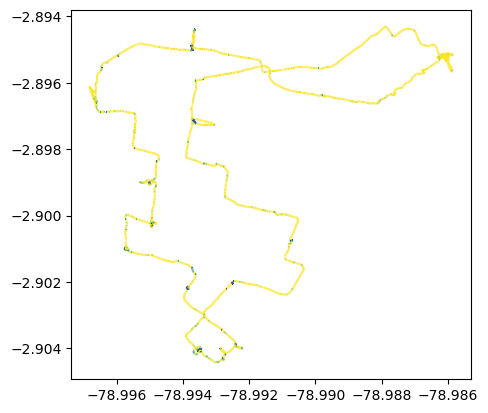

In [9]:
traj.plot(column='speed', vmax=1)


### Outlier cleaner

Outlier cleaning based in thresholds/quantile outliers, the method used is the IQR scoring method (https://en.wikipedia.org/wiki/Interquartile_range) 

This method detects the records that exists outside a quantile range that is picked based on the variance of the data and the alpha value picked to identify records that are considered noise/error, the larger the alpha, the wider the range of acceptable values

#### Max speed values after cleaning 

In [10]:
speed = pd.DataFrame(cleaned.df).sort_values(by='speed', ascending=False)
speed_km_h = speed['speed']*3600/1000
speed_km_h.head(20)

time
2023-04-28 09:38:10    6.324970
2023-04-28 09:38:09    6.324970
2023-04-28 09:38:07    6.324970
2023-04-28 07:32:47    6.324966
2023-04-28 07:43:41    6.324966
2023-04-28 07:44:17    6.324965
2023-04-28 07:33:50    6.324964
2023-04-28 07:33:59    6.324964
2023-04-28 07:38:35    6.324963
2023-04-28 09:08:25    6.324960
2023-04-28 07:48:33    6.324959
2023-04-28 07:48:30    6.324959
2023-04-28 07:48:26    6.324959
2023-04-28 09:05:06    6.324954
2023-04-28 09:05:05    6.324954
2023-04-28 08:26:11    6.324925
2023-04-28 09:18:49    6.297590
2023-04-28 09:20:44    6.297590
2023-04-28 09:43:35    6.297590
2023-04-28 07:41:26    6.297590
Name: speed, dtype: float64

### Smoother - KalmanSmootherCV

This smoother operates on the assumption of a nearly-constant velocity (CV) model. The process_noise_std and measurement_noise_std parameters can be used to tune the smoother:

process_noise_std governs the uncertainty associated with the adherence of the new (smooth) trajectories to the CV model assumption; higher values relax the assumption, therefore leading to less-smooth trajectories, and vice-versa.
measurement_noise_std controls the assumed error in the original trajectories; higher values dictate that the original trajectories are expected to be noisier (and therefore, less reliable), thus leading to smoother trajectories, and vice-versa.

### Compare

In [11]:
hvplot_defaults = {'tiles':'CartoLight', 'frame_height':320, 'frame_width':320, 'cmap':'Viridis', 'colorbar':True}
kwargs = {**hvplot_defaults, 'line_width':4}


In [12]:
smoothed = mpd.KalmanSmootherCV(cleaned).smooth(process_noise_std=0.1, measurement_noise_std=10)
    
(traj.hvplot(title='Original Trajectory', **kwargs) + 
 cleaned.hvplot(title='Cleaned Trajectory', **kwargs) + 
 smoothed.hvplot(title='Cleaned & Smoothed Trajectory', **kwargs))

:Layout
   .Overlay.I   :Overlay
      .Tiles.I  :Tiles   [x,y]
      .Path.I   :Path   [Longitude,Latitude]
      .Points.I :Points   [Longitude,Latitude]   (triangle_angle)
   .Overlay.II  :Overlay
      .Tiles.I  :Tiles   [x,y]
      .Path.I   :Path   [Longitude,Latitude]
      .Points.I :Points   [Longitude,Latitude]   (triangle_angle)
   .Overlay.III :Overlay
      .Tiles.I  :Tiles   [x,y]
      .Path.I   :Path   [Longitude,Latitude]
      .Points.I :Points   [Longitude,Latitude]   (triangle_angle)

In [31]:
speed = pd.DataFrame(smoothed.df).sort_values(by='speed', ascending=False)
speed_km_h = speed['speed']*3600/1000
speed_km_h.head(20)

time
2023-04-28 09:38:10    6.324970
2023-04-28 09:38:09    6.324970
2023-04-28 09:38:07    6.324970
2023-04-28 07:32:47    6.324966
2023-04-28 07:43:41    6.324966
2023-04-28 07:44:17    6.324965
2023-04-28 07:33:50    6.324964
2023-04-28 07:33:59    6.324964
2023-04-28 07:38:35    6.324963
2023-04-28 09:08:25    6.324960
2023-04-28 07:48:33    6.324959
2023-04-28 07:48:30    6.324959
2023-04-28 07:48:26    6.324959
2023-04-28 09:05:06    6.324954
2023-04-28 09:05:05    6.324954
2023-04-28 08:26:11    6.324925
2023-04-28 09:18:49    6.297590
2023-04-28 09:20:44    6.297590
2023-04-28 09:43:35    6.297590
2023-04-28 07:41:26    6.297590
Name: speed, dtype: float64

<Axes: >

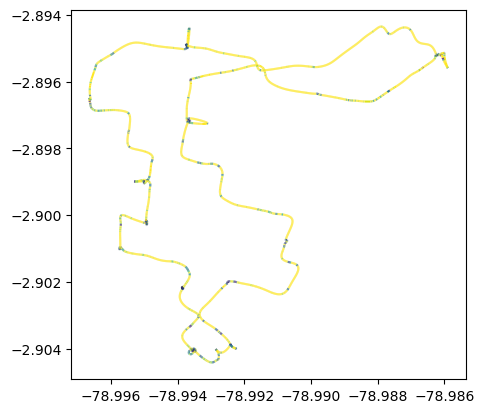

In [32]:
smoothed.plot(column='speed', vmax=1)